In [1]:
import sqlite3
import pandas
con = sqlite3.connect('coal.db')
plant_labels = pandas.read_sql("select orispl_code, unitid from data group by orispl_code, unitid", con)

In [2]:
# Step 1: loading data
import csv
import numpy as np
import os.path
to_ml = []
to_plot = []
labels = []
for i, row in plant_labels.iterrows():
    for year in range(2001, 2017):
        file_name = 'cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        with open(file_name, 'rb') as csvfile:
            dr = csv.DictReader(csvfile)
            to_insert = []
            for row in dr:
                to_insert.append(float(row['capacity_factor']))
                if int(row['']) % 24 is 23:
                    to_plot.append(to_insert)
                    to_ml.append(to_insert + np.gradient(to_insert).tolist())
                    labels.append((row['op_date'], row['name'], row['unitid']))
                    to_insert = []

In [3]:
# Step 2: normalize data
from sklearn.preprocessing import normalize
normalized = normalize(to_ml)

In [13]:
# Step 3: run kmeans
clusters = 20
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=0).fit(normalized)

In [14]:
output = kmeans.labels_

In [15]:
import shutil
import os.path
if os.path.exists('kmeans_' + str(clusters)):
    shutil.rmtree('kmeans_' + str(clusters))

In [16]:
# Save images to inspect results
import os.path
import matplotlib.pyplot as plt
import random
counts = clusters * [0]
totals = clusters * [np.zeros(24)]
for i in range(clusters):
    if not os.path.exists('kmeans_' + str(clusters)+ '/' + str(i)):
        os.makedirs('kmeans_' + str(clusters) + '/' + str(i))
for i in range(len(normalized)):
    counts[output[i]] += 1
    totals[output[i]] = to_plot[i] + totals[output[i]]
    # Sample .1% of days (~500 total) to verify that clusters are working 
    if random.randint(1, 1000) is not 100: continue
    plt.gcf().clear()
    plt.axis([0, 24, 0, 1])
    plt.plot(to_plot[i])
    plt.savefig('kmeans_' + str(clusters) + '/' + str(output[i]) + '/' + str(labels[i][1]) + '_' + str(labels[i][2]) + '_' + str(labels[i][0]) + '.png')


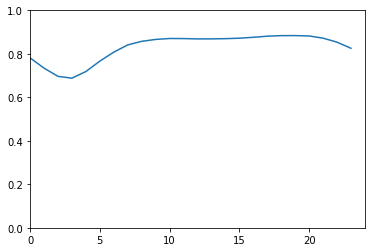

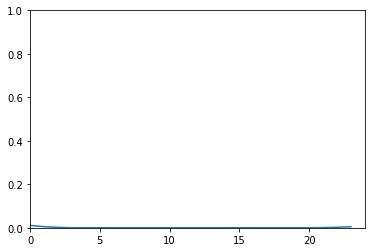

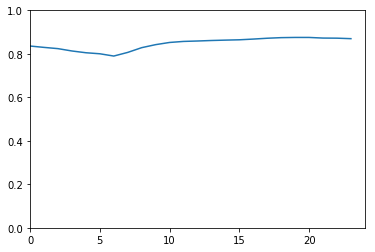

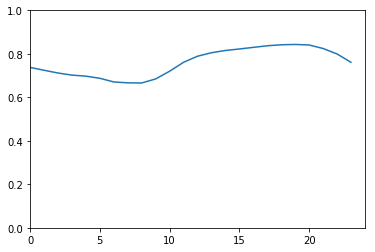

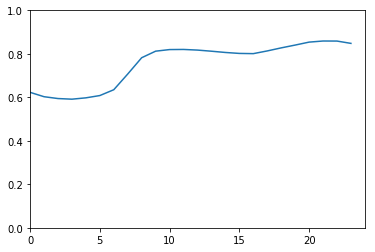

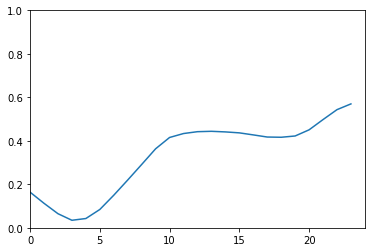

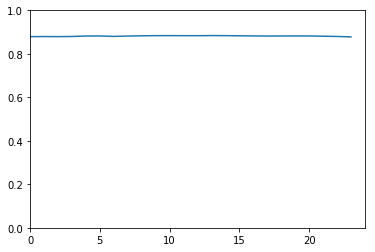

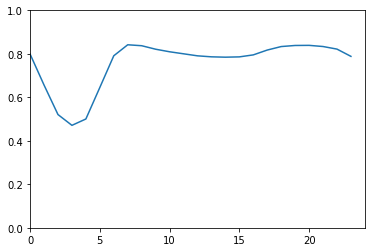

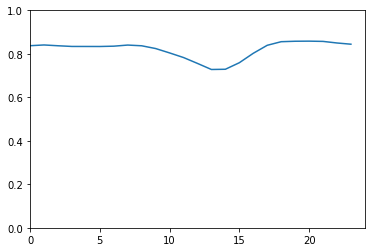

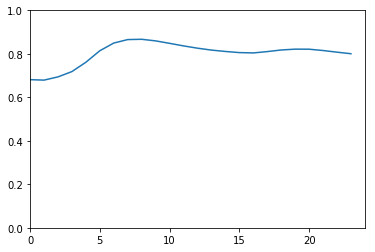

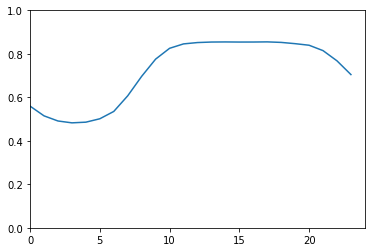

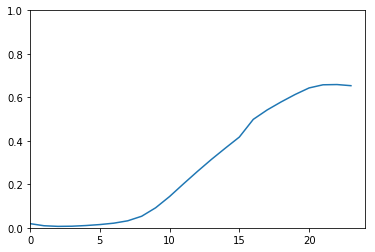

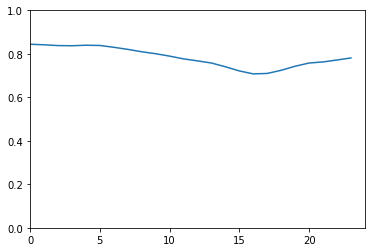

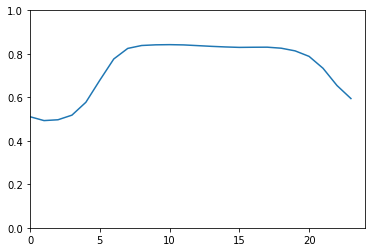

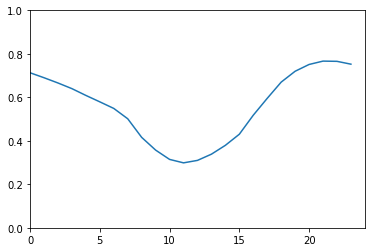

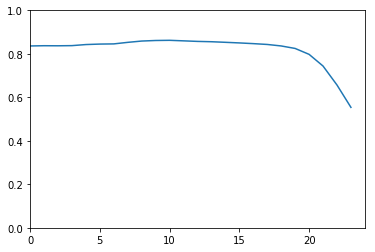

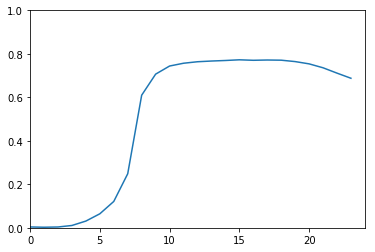

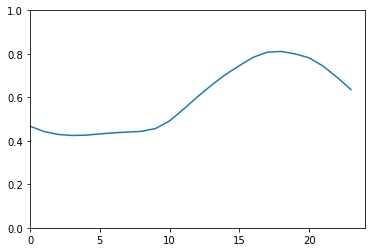

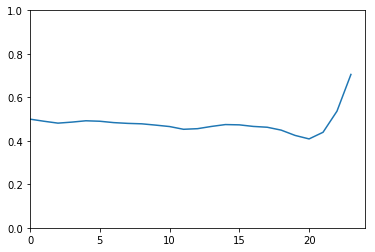

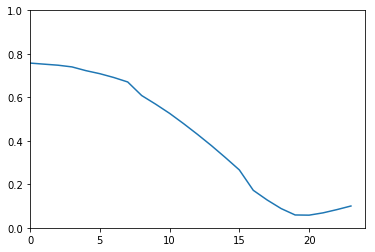

In [26]:
for i in range(clusters):
    values = totals[i] / counts[i]
    plt.gcf().clear()
    plt.axis([0, 24, 0, 1])
    plt.plot(values)
    plt.title("Cluster " + str(i) + " Average Shape")
    plt.xlabel('Hour')
    plt.ylabel('Capacity Factor')
    plt.savefig('kmeans_' + str(clusters) + '/average' + str(i) + ".png")
    plt.show()


In [18]:
def get_counts(filename):
    to_test = []
    with open(filename, 'rb') as csvfile:
        dr = csv.DictReader(csvfile)
        to_insert = []
        for row in dr:
            to_insert.append(float(row['capacity_factor']))
            if int(row['']) % 24 is 23:
                to_test.append(to_insert + np.gradient(to_insert).tolist())
                to_insert = []
    result = kmeans.predict(normalize(to_test))
    counts = clusters * [0]
    for i in range(len(result)):
        counts[result[i]] += 1
    return counts

In [27]:
for entry in get_counts('cf/6481_1SGA_2001.csv'):
    print entry
for entry in get_counts('cf/6481_1SGA_2006.csv'):
    print entry
for entry in get_counts('cf/6481_1SGA_2011.csv'):
    print entry
for entry in get_counts('cf/6481_1SGA_2016.csv'):
    print entry

9
37
71
3
0
0
217
1
3
0
0
6
2
2
2
9
1
0
0
2
5
0
22
1
0
0
291
0
5
15
0
1
3
2
4
14
0
1
0
0
101
47
38
8
10
2
66
3
4
5
44
1
2
22
3
5
0
3
0
1
19
37
20
55
10
1
48
9
6
6
11
2
8
21
25
4
0
82
1
1


In [29]:
def get_year(year):
    to_test = []
    for i, row in plant_labels.iterrows():
        file_name = 'cf/' + str(row['orispl_code']) + '_' + row['unitid'] + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        with open(file_name, 'rb') as csvfile:
            dr = csv.DictReader(csvfile)
            to_insert = []
            for row in dr:
                to_insert.append(float(row['capacity_factor']))
                if int(row['']) % 24 is 23:
                    to_test.append(to_insert + np.gradient(to_insert).tolist())
                    to_insert = []
    result = kmeans.predict(normalize(to_test))
    counts = clusters * [0]
    for i in range(len(result)):
        counts[result[i]] += 1
    return counts

def get_plant_year(year, orispl_code):
    to_test = []
    for i, row in plant_labels.iterrows():
        file_name = 'cf/' + str(orispl_code) + '_' + row['unitid'] + '_' + str(year) + '.csv'
        if not os.path.isfile(file_name): continue
        with open(file_name, 'rb') as csvfile:
            dr = csv.DictReader(csvfile)
            to_insert = []
            for row in dr:
                to_insert.append(float(row['capacity_factor']))
                if int(row['']) % 24 is 23:
                    to_test.append(to_insert + np.gradient(to_insert).tolist())
                    to_insert = []
    result = kmeans.predict(normalize(to_test))
    counts = clusters * [0]
    for i in range(len(result)):
        counts[result[i]] += 1
    return counts

In [21]:
for entry in get_year(2001):
    print entry
for entry in get_year(2016):
    print entry

2092
2929
2769
657
438
121
17252
226
658
824
1141
398
863
792
181
1310
67
212
12
397
[2102, 6585, 1768, 1821, 559, 71, 6893, 198, 1514, 1524, 1386, 273, 1508, 1563, 493, 1023, 35, 1144, 27, 319]


In [32]:
for entry in get_plant_year(2001, 8066):
    print entry
for entry in get_plant_year(2006, 8066):
    print entry
for entry in get_plant_year(2011, 8066):
    print entry
for entry in get_plant_year(2016, 8066):
    print entry

95
85
137
18
20
7
711
6
62
29
59
18
42
72
3
71
6
4
0
15
91
115
58
27
14
5
808
9
30
54
42
24
61
31
10
43
7
8
1
22
148
161
68
68
64
3
266
11
28
66
185
17
70
166
12
70
3
39
1
14
136
191
102
130
85
3
112
8
100
117
78
10
151
59
35
86
2
41
2
16
